<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905 entries, 0 to 904
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sale_id       905 non-null    int64  
 1   channel       905 non-null    object 
 2   discounted    905 non-null    int64  
 3   total_amount  905 non-null    float64
 4   sale_date     905 non-null    object 
 5   customer_id   905 non-null    int64  
 6   country       905 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 49.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  1000 non-null   int64 
 1   country      1000 non-null   object
 2   age_range    1000 non-null   object
 3   signup_date  1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB
None
   customer_id  recency  frequency

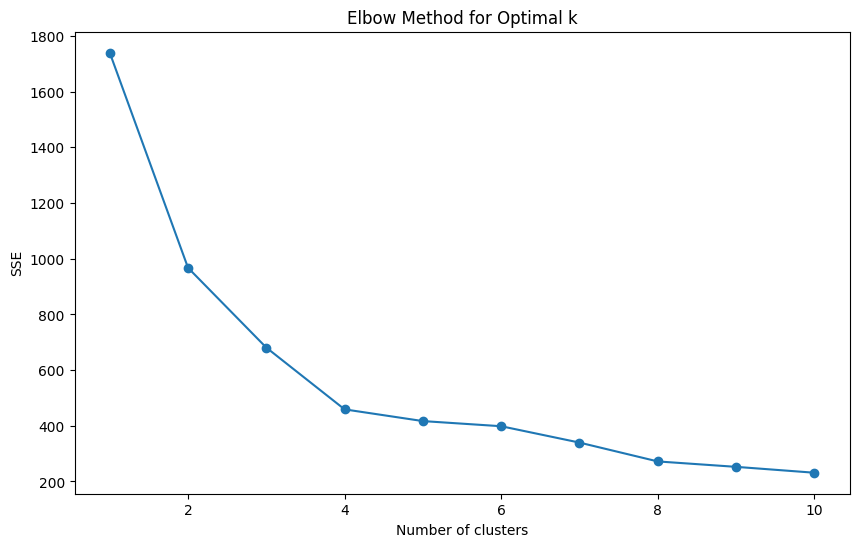

In [69]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv('customers.csv')
sales = pd.read_csv('sales.csv')
salesitems = pd.read_csv('salesitems.csv')

print(sales.info())
print(customers.info())

# Merge sales with customers on 'customer_id'
sales_agg = sales.groupby('customer_id').agg(
    total_sales = pd.NamedAgg(column='total_amount', aggfunc='sum'),
    num_orders = pd.NamedAgg(column='sale_id', aggfunc='count'),
    last_order_date = pd.NamedAgg(column='sale_date', aggfunc='max'),
    avg_order_value = pd.NamedAgg(column='total_amount', aggfunc='mean')
).reset_index()

# create RFM table
rfm = sales_agg.merge(customers, on='customer_id', how='left')

rfm['last_order_date'] = pd.to_datetime(rfm['last_order_date'])
rfm['recency'] = (pd.Timestamp('now') - rfm['last_order_date']).dt.days
rfm = rfm.rename(columns={'num_orders': 'frequency', 'total_sales': 'monetary'})
rfm = rfm[['customer_id', 'recency', 'frequency', 'monetary', 'avg_order_value']]
print(rfm.head())

# Standardize RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])

# Determine optimal number of clusters using Elbow Method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show() 


In [70]:
# From the elbow plot, choose k=4
optimal_k = 4
# Apply KMeans with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['cluster'] = kmeans.fit_predict(rfm_scaled)

rfm_summary = rfm.groupby('cluster')[['recency', 'frequency', 'monetary', 'avg_order_value']].mean().reset_index()
print(rfm_summary)

   cluster     recency  frequency     monetary  avg_order_value
0        0  168.357143   1.115385   384.289286       349.365357
1        1  130.975610   2.073171   742.697317       361.507591
2        2  135.411765   3.450980  1348.396863       396.471377
3        3  132.240437   1.016393   348.226284       345.889180


Text(0.5, 1.0, 'Total Sales per Cluster')

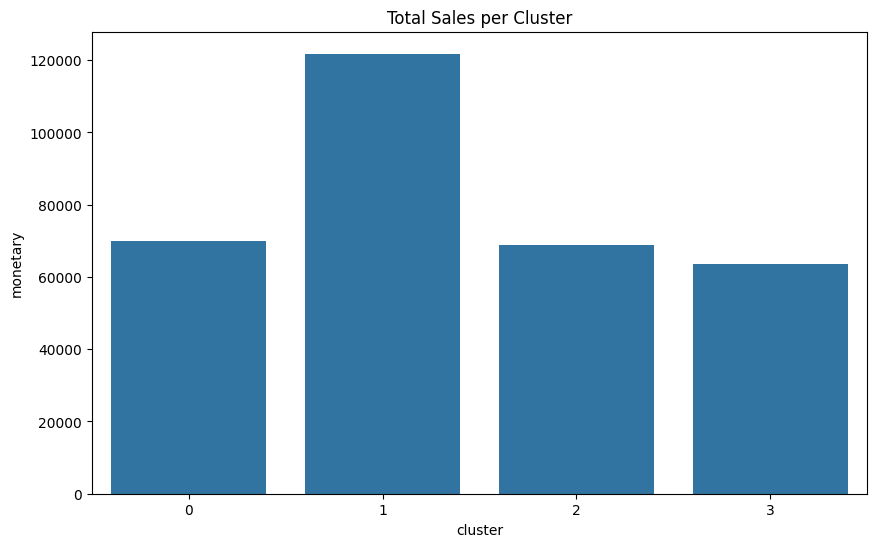

In [71]:
total_sales_per_cluster = rfm.groupby('cluster')['monetary'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=total_sales_per_cluster, x='cluster', y='monetary')
plt.title('Total Sales per Cluster')


From the exploratary analysis, noted that cluster has significantly higher average order value and purchase frequency, but as a group the contribution to total sales is not as much as cluster 1. To ensure the correct segmentation, observe the total customers in each segments.

In [72]:
cluster_labels = { 0: 'Lost Customers', 1: 'Loyal Customers', 2: 'Champions', 3: 'At Risk' }
rfm['segment'] = rfm['cluster'].map(cluster_labels)
print(rfm['segment'].value_counts())

segment
At Risk            183
Lost Customers     182
Loyal Customers    164
Champions           51
Name: count, dtype: int64


Create 3D Customer Clusters

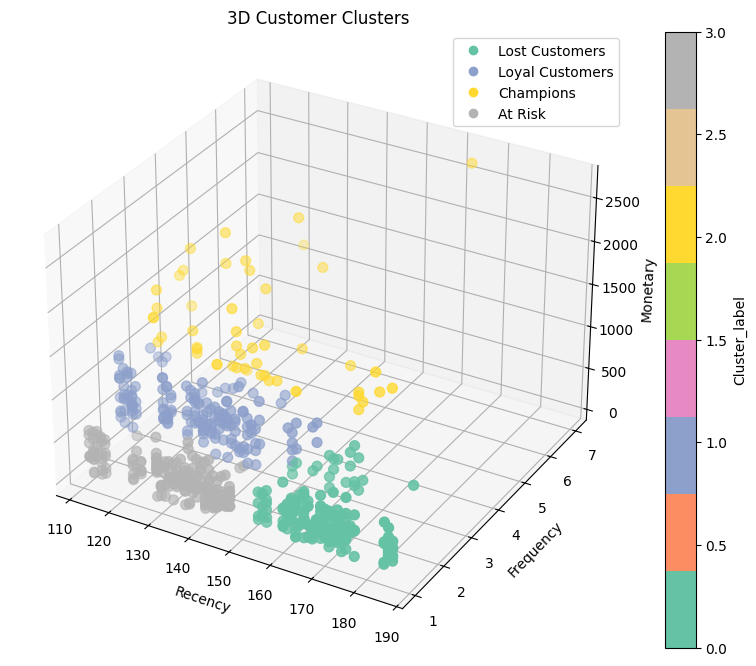

In [73]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    rfm['recency'], rfm['frequency'], rfm['monetary'],
    c=rfm['cluster'], cmap='Set2', s=50
)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D Customer Clusters')
plt.colorbar(scatter, label='Cluster_label')
plt.legend(handles=scatter.legend_elements()[0], labels=cluster_labels.values())
plt.show()

Now that we have a fundamental understanding of the customer segments — including high-value customers (Champions) who exhibit high frequency, high recency, and high monetary contribution; at-risk customers with declining frequency and signs of churn; lost customers with both low frequency and low recency; and loyal customers who purchase frequently and recently — this analysis empowers the marketing team to design more effective marketing and CRM strategies based on data-driven insights.

From the RFM analysis, we understand the level of customer activity. To gain deeper insight into customer behaviour, we will further explore:

- Timing & habit: What is the average purchase interval for each segment? When do they tend to make purchases (peak time)?

- Channel reliance: How do they rely on different channels? Do some segments prefer specific ones?

- Product preference & price sensitivity: What product types or price ranges do they favour?

- Demographics: How do age, gender, and country shape each segment’s persona?

- Customer life cycle: How long does it take from registration to the first purchase?


     cluster_label  purchase_interval
0          At Risk          30.000000
1        Champions          14.239869
2   Lost Customers           8.476190
3  Loyal Customers          24.945122


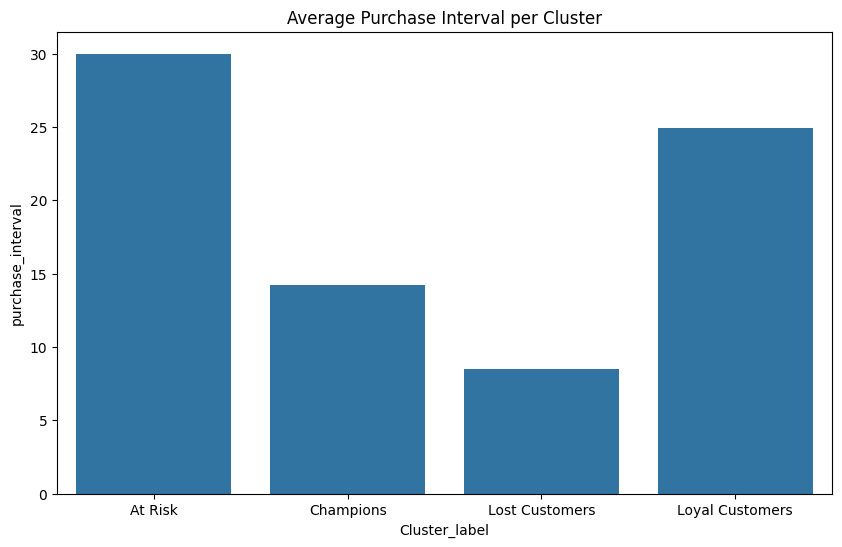

In [74]:
rfm['cluster_label'] = rfm['cluster'].map(cluster_labels)

# Purchase interval per customer
df_sorted  = sales.sort_values(by=['customer_id', 'sale_date'])
df_sorted['sale_date'] = pd.to_datetime(df_sorted['sale_date'])
df_sorted['prev_sale_date'] = df_sorted.groupby('customer_id')['sale_date'].shift(1)
df_sorted['purchase_interval'] = (df_sorted['sale_date'] - df_sorted['prev_sale_date']).dt.days
avg_purchase_interval = df_sorted.groupby('customer_id')['purchase_interval'].mean().reset_index()
avg_purchase_interval = avg_purchase_interval.merge(rfm[['customer_id', 'cluster_label']], on='customer_id', how='left')
interval_summary = avg_purchase_interval.groupby('cluster_label')['purchase_interval'].mean().reset_index()
print(interval_summary)
plt.figure(figsize=(10, 6))
sns.barplot(data=interval_summary, x='cluster_label', y='purchase_interval')
plt.title('Average Purchase Interval per Cluster')
plt.xlabel('Cluster_label')
plt.show()

In [75]:
# Peak purchase day of week
sales['day_of_week'] = sales['sale_date'].dt.day_name()
sales['sale_date'] = pd.to_datetime(sales['sale_date'])
peak_days = sales.merge(rfm[['customer_id', 'cluster_label']], on='customer_id').groupby(['cluster_label', 'day_of_week']).size().reset_index(name='count')
peak_days = peak_days.sort_values(['cluster_label', 'count'], ascending=[True, False])

plt.figure(figsize=(12, 8))
sns.barplot(data=peak_days, x='day_of_week', y='count', hue='cluster_label')
plt.title('Peak Purchase Days of the Week by Cluster')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Purchases')
plt.legend(title='Cluster_label')
plt.show()


AttributeError: Can only use .dt accessor with datetimelike values

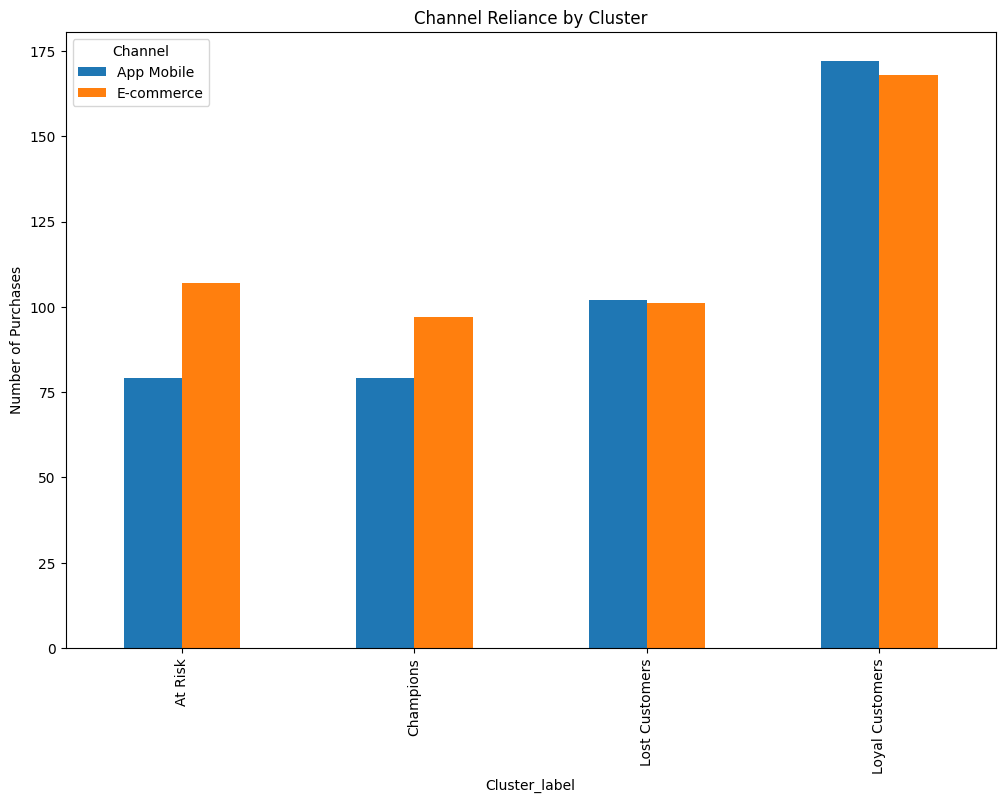

In [ ]:
# channel reliance
channel_summary = sales.merge(rfm[['customer_id', 'cluster_label']], on='customer_id').groupby(['cluster_label', 'channel']).size().reset_index(name='count')
channel_pivot = channel_summary.pivot(index='cluster_label', columns='channel', values='count').fillna(0)
channel_pivot.plot(kind='bar', figsize=(12, 8))
plt.title('Channel Reliance by Cluster')
plt.xlabel('Cluster_label')
plt.ylabel('Number of Purchases')
plt.legend(title='Channel')
plt.show()

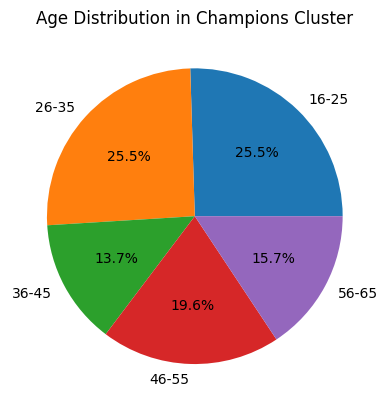

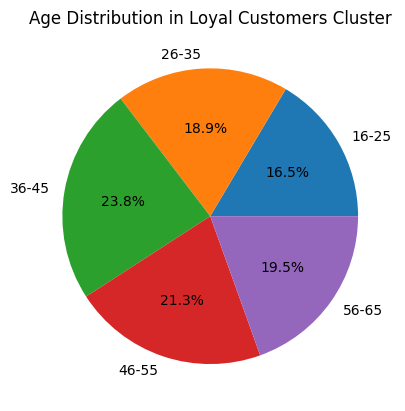

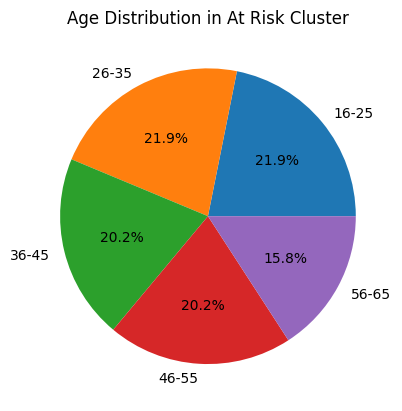

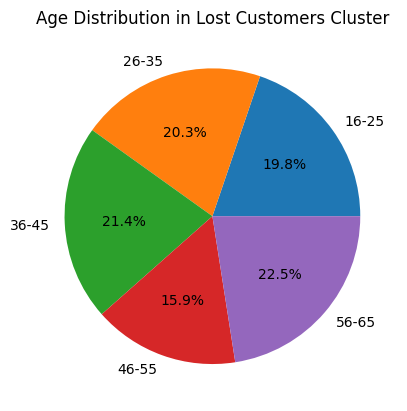

In [ ]:
# demographics summary
demographics = customers.merge(rfm[['customer_id', 'cluster_label']], on='customer_id', how='left')
age_summary = demographics.groupby(['cluster_label', 'age_range']).size().reset_index(name='count')
plt.pie(age_summary[age_summary['cluster_label'] == 'Champions']['count'], labels=age_summary[age_summary['cluster_label'] == 'Champions']['age_range'], autopct='%1.1f%%')
plt.title('Age Distribution in Champions Cluster')
plt.show()

plt.pie(age_summary[age_summary['cluster_label'] == 'Loyal Customers']['count'], labels=age_summary[age_summary['cluster_label'] == 'Loyal Customers']['age_range'], autopct='%1.1f%%')
plt.title('Age Distribution in Loyal Customers Cluster')
plt.show()

plt.pie(age_summary[age_summary['cluster_label'] == 'At Risk']['count'], labels=age_summary[age_summary['cluster_label'] == 'At Risk']['age_range'], autopct='%1.1f%%')
plt.title('Age Distribution in At Risk Cluster')
plt.show()

plt.pie(age_summary[age_summary['cluster_label'] == 'Lost Customers']['count'], labels=age_summary[age_summary['cluster_label'] == 'Lost Customers']['age_range'], autopct='%1.1f%%'    )
plt.title('Age Distribution in Lost Customers Cluster')
plt.show()

     cluster_label  days_to_first_purchase
0          At Risk               59.721311
1        Champions               40.745098
2   Lost Customers               22.923077
3  Loyal Customers               47.237805


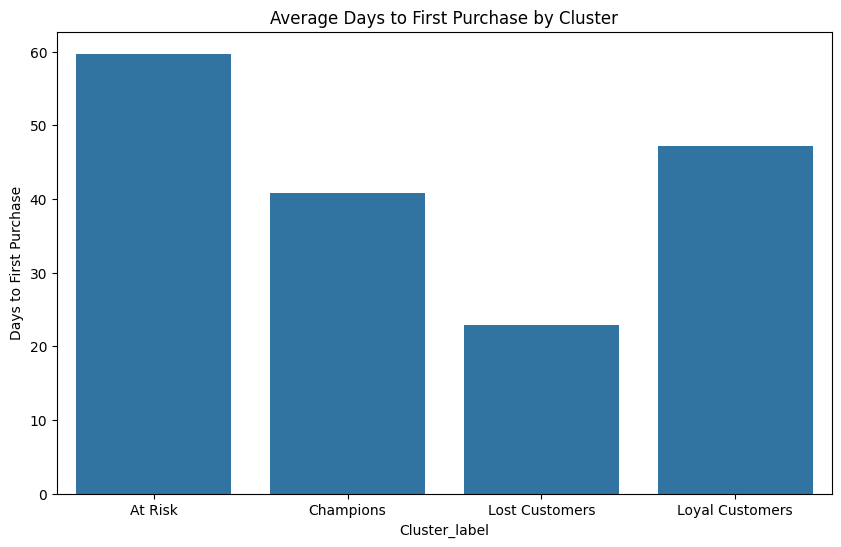

In [82]:
# customer life cycle
first_purchase = sales.sort_values(by=['customer_id', 'sale_date']).groupby('customer_id').first().reset_index()
first_purchase = first_purchase[['customer_id', 'sale_date']]
first_purchase = first_purchase.rename(columns={'sale_date': 'first_purchase_date'})
first_purchase['first_purchase_date'] = pd.to_datetime(first_purchase['first_purchase_date'])
customer_lifecycle = customers.merge(first_purchase, on='customer_id').merge(rfm[['customer_id', 'cluster_label']], on='customer_id', how='left')
customer_lifecycle['signup_date'] = pd.to_datetime(customer_lifecycle['signup_date'])
customer_lifecycle['days_to_first_purchase'] = (customer_lifecycle['first_purchase_date'] - customer_lifecycle['signup_date']).dt.days
lifecycle_summary = customer_lifecycle.groupby('cluster_label')['days_to_first_purchase'].mean().reset_index()
print(lifecycle_summary)
plt.figure(figsize=(10, 6))
sns.barplot(data=lifecycle_summary, x='cluster_label', y='days_to_first_purchase')
plt.title('Average Days to First Purchase by Cluster')
plt.xlabel('Cluster_label')
plt.ylabel('Days to First Purchase')
plt.show()

Export all analysis summary to .csv as the basis of the dashboard.

In [97]:
Customer_insights = rfm.merge(avg_purchase_interval[['customer_id', 'purchase_interval']], on='customer_id', how='left').merge(lifecycle_summary, on='cluster_label', how='left')
Customer_insights = Customer_insights.merge(demographics[['customer_id', 'age_range', 'country']], on='customer_id', how='left')
Customer_insights = Customer_insights.merge(channel_summary, on='cluster_label', how='left')
Customer_insights = Customer_insights.merge(lifecycle_summary, on='cluster_label', how='left')
Customer_insights.to_csv('customer_insights.csv', index=False)
